In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import glob
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
import kaldi_io
%matplotlib widget

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [24]:
china_mfcc = glob.glob("/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw*.scp")
taiwan_mfcc = glob.glob("/home/espnet/egs2/chatbot/tts1/dump/mfcc/train_no_dev_test_phn/data/raw*.scp")

In [18]:
china_mfcc 

['/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.18.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.7.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.24.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.8.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.26.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.9.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.19.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.3.scp',
 '/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.22.scp',
 '/home/espnet/egs2/ais

In [26]:
from kaldiio import ReadHelper
test_embeddings = torch.zeros((0, 30), dtype=torch.float32)
label = []
for each in tqdm(china_mfcc):
    with ReadHelper(f"scp:{each}") as reader:
        for key,  numpy_array in reader:
            c = torch.from_numpy(numpy_array)
            c = torch.mean(c, dim=0, keepdim=True)
            test_embeddings = torch.cat((test_embeddings,c),0)
            label.append(0)
for each in tqdm(taiwan_mfcc):
    with ReadHelper(f"scp:{each}") as reader:
        for key,  numpy_array in reader:
            t = torch.from_numpy(numpy_array)
            t = torch.mean(t, dim=0, keepdim=True)
            test_embeddings = torch.cat((test_embeddings,t),0)
            label.append(1)
            # taiwan = np.load(taiwan_feats_dict[taiwan_feats_dict_keys[-1]][key])  
            # t= torch.from_numpy(taiwan)
            # t = t[0*2-1].mean(dim=1)
            # test_embeddings = torch.cat((test_embeddings,t),0)
            # accent.append(1)

100%|██████████| 32/32 [00:00<00:00, 233.73it/s]


In [29]:
label = np.array(label)

In [3]:
feat_reader = kaldi_io.SequentialBaseFloatMatrixReader('scp:/home/espnet/egs2/aishell3/tts1/dump/mfcc/pair_no_dev_test_phn/data/raw_mfcc_pair_no_dev_test_phn.1.scp')

AttributeError: module 'kaldi_io' has no attribute 'SequentialBaseFloatMatrixReader'

In [2]:
china_root = "/home/espnet/egs2/aishell3/tts1/"
china_accent_path = "/home/espnet/egs2/aishell3/tts1/exp/tts_train_gst+xvector_conformer_fastspeech2_raw_phn_pypinyin_g2p_phone/ForMeasureDistance/pair_test_phn/latent"
taiwan_accent_root = "/home/espnet/egs2/chatbot/tts1/exp/tts_finetune_fastpeech2_reprogram_save_all_g2pw"
taiwan_accent_root_add = "/home/espnet/egs2/chatbot/tts1/exp/tts_finetune_fastpeech2_consistent_test_400_fixweight_e3_saveall_g2pw"

In [3]:
china_feats_dict={}
with open(os.path.join(china_accent_path,"feats.scp"),'r') as c:
    for line in c.readlines():
        uid, feats_path = line.strip("\n").split(" ")
        feats_path = os.path.join(china_root,feats_path)
        if os.path.exists(feats_path):
            china_feats_dict[uid] = feats_path 

In [4]:

epoch_feats_paths = glob.glob(os.path.join(taiwan_accent_root,"decode_*epoch"))
len(epoch_feats_paths)

16

In [5]:
taiwan_feats_dict = {}
for epoch_feats_path in epoch_feats_paths:
    folder_name = epoch_feats_path.split("/")[-1]
    taiwan_feats_dict[folder_name] = {}
    with open(os.path.join(epoch_feats_path,'test_phn','latent','feats.scp')) as f:
        for line in f.readlines():
            uid, feats_path = line.strip("\n").split(" ")
            feats_path = feats_path.replace("tts_finetune_fastpeech2_reprogram_decoder_Onlydependence_withlatent_save_all_g2pw","tts_finetune_fastpeech2_reprogram_save_all_g2pw")
            # feats_path.replace(""tts_finetune_fastpeech2_reprogram_save_all_g2pw")
            feats_path = "./" + feats_path
            if os.path.exists(feats_path):
                taiwan_feats_dict[folder_name][uid] = feats_path 
            else:
                print(feats_path)

taiwan_feats_dict_keys = sorted(taiwan_feats_dict, key=lambda x: int(x.lstrip('decode_').rstrip("epoch")))

In [22]:
accent = []
test_embeddings = torch.zeros((0, 384), dtype=torch.float32)
# for i in range(5):
for idx, key in enumerate(china_feats_dict):
    china = np.load(china_feats_dict[key])
    c = torch.from_numpy(china)
    c = c[0].mean(dim=1)
    test_embeddings = torch.cat((test_embeddings,c),0)
    accent.append(0)
    taiwan = np.load(taiwan_feats_dict[taiwan_feats_dict_keys[-1]][key])  
    t= torch.from_numpy(taiwan)
    t = t[0*2-1].mean(dim=1)
    test_embeddings = torch.cat((test_embeddings,t),0)
    accent.append(1)
    
    # t = torch.from_numpy(t).to(device)


In [ ]:
accent

In [23]:
accent = np.array(accent)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1752 samples in 0.000s...
[t-SNE] Computed neighbors for 1752 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1752
[t-SNE] Computed conditional probabilities for sample 1752 / 1752
[t-SNE] Mean sigma: 5.276735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.078186
[t-SNE] KL divergence after 1000 iterations: 1.599947


/tmp/ipykernel_2834333/3069048406.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


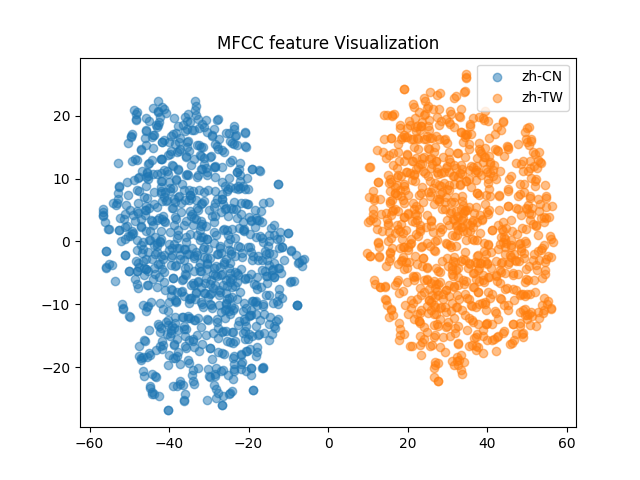

In [35]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots()
num_categories = 2
label_map = {0:"zh-CN", 1:"zh-TW"}
for lab in range(num_categories):
    indices = label==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = label_map[lab] ,alpha=0.5)
ax.legend(markerscale=1)
ax.set_title("MFCC feature Visualization")
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.437731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.462524
[t-SNE] KL divergence after 1000 iterations: 0.116093


/tmp/ipykernel_2833674/1151582003.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


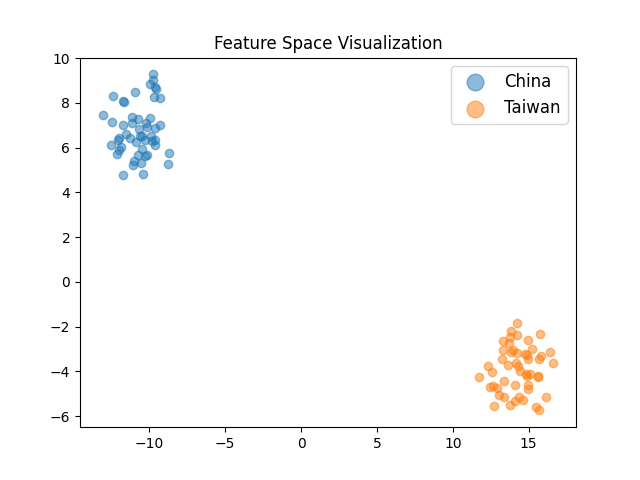

In [30]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots()
num_categories = 2
label_map = {0:"China", 1:"Taiwan"}
for lab in range(num_categories):
    indices = accent==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = label_map[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
ax.set_title("Feature Space Visualization")
plt.show()